In [1]:
import xarray as xr
import numpy as np
import sys; sys.path.append('../src/training-on-CM2.6')
import matplotlib.pyplot as plt
from helpers.plot_helpers import *
import cmocean
import xgcm
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [2]:
def sort_longitude(_x, lon_min=-180.):
    if lon_min is None:
        return _x
    lon_max=lon_min + 360.

    x = _x.copy()

    for lon in ['xh', 'xq', 'lon']:
        try:
            lon = x[lon]
            if lon.min() < lon_min:
                lon = xr.where(lon<lon_min, lon+360, lon)
                lon = xr.where(lon>lon_max, lon-360, lon)
            else:
                lon = xr.where(lon>lon_max, lon-360, lon)
                lon = xr.where(lon<lon_min, lon+360, lon)   
            x[lon.name] = lon.copy()
            
            x = x.sortby(lon.name)
        except:
            pass
    return x

In [3]:
# 146 snapshots every 3 days
obs = sort_longitude(xr.open_dataset('/scratch/pp2681/altimetry_Copernicus.nc', chunks={'time':1}).adt.sel(time=slice('2002','2003',3)).rename({'longitude':'lon', 'latitude':'lat'}))

In [4]:
control = sort_longitude(xr.open_mfdataset(['/scratch/js15017/OM4_storage/CORE-AIF-runs/unparameterized/20020101.ocean_daily_00730365.nc',
                             '/scratch/js15017/OM4_storage/CORE-AIF-runs/unparameterized/20030101.ocean_daily_00730730.nc'], 
                             chunks={'time':1}, parallel=True, combine='nested', compat='no_conflicts', concat_dim='time').zos.sel(time=slice(None,None,3)))

In [5]:
ann = sort_longitude(xr.open_mfdataset(['/scratch/js15017/OM4_storage/CORE-AIF-runs/ANN/20020101.ocean_daily_00730365.nc',
                             '/scratch/js15017/OM4_storage/CORE-AIF-runs/ANN/20030101.ocean_daily_00730730.nc'], 
                             chunks={'time':1}, parallel=True, combine='nested', compat='no_conflicts', concat_dim='time').zos.sel(time=slice(None,None,3)))

# Interpolate data on common grid

In [6]:
control_regrid = control.interp(xh=obs.lon, yh=obs.lat)
ann_regrid = ann.interp(xh=obs.lon, yh=obs.lat)

In [7]:
# Create grid for observations
param_obs = xr.Dataset()
param_obs['lon'] = obs['lon']
param_obs['lat'] = obs['lat']
param_obs['lonq'] = (obs['lon'] + 0.25/2).rename({'lon':'lonq'})
param_obs['latq'] = (obs['lat'] + 0.25/2).rename({'lat':'latq'})

grid = xgcm.Grid(param_obs, coords={
            'X': {'center': 'lon', 'right': 'lonq'},
            'Y': {'center': 'lat', 'right': 'latq'}
        },
        boundary={"X": 'periodic', 'Y': 'fill'},
        fill_value = {'Y':np.nan})

Rearth = 6.378e+6 # in metres
param_obs['dy'] = Rearth * np.deg2rad(0.25)
param_obs['dx'] = Rearth * np.deg2rad(0.25) * np.cos(np.deg2rad(param_obs['lat']))
#param_obs['dxq'] = Rearth * np.deg2rad(0.25) * np.cos(np.deg2rad(param_obs['latq']))

In [8]:
def abs_grad(ssh):
    ssh_x = grid.interp(grid.diff(ssh, 'X') / param_obs['dx'],'X')
    ssh_y = grid.interp(grid.diff(ssh, 'Y') / param_obs['dy'],'Y')

    out = np.sqrt(ssh_x**2 + ssh_y**2)
    out['time'] = ssh['time']
    return out.where(out.lat<65)

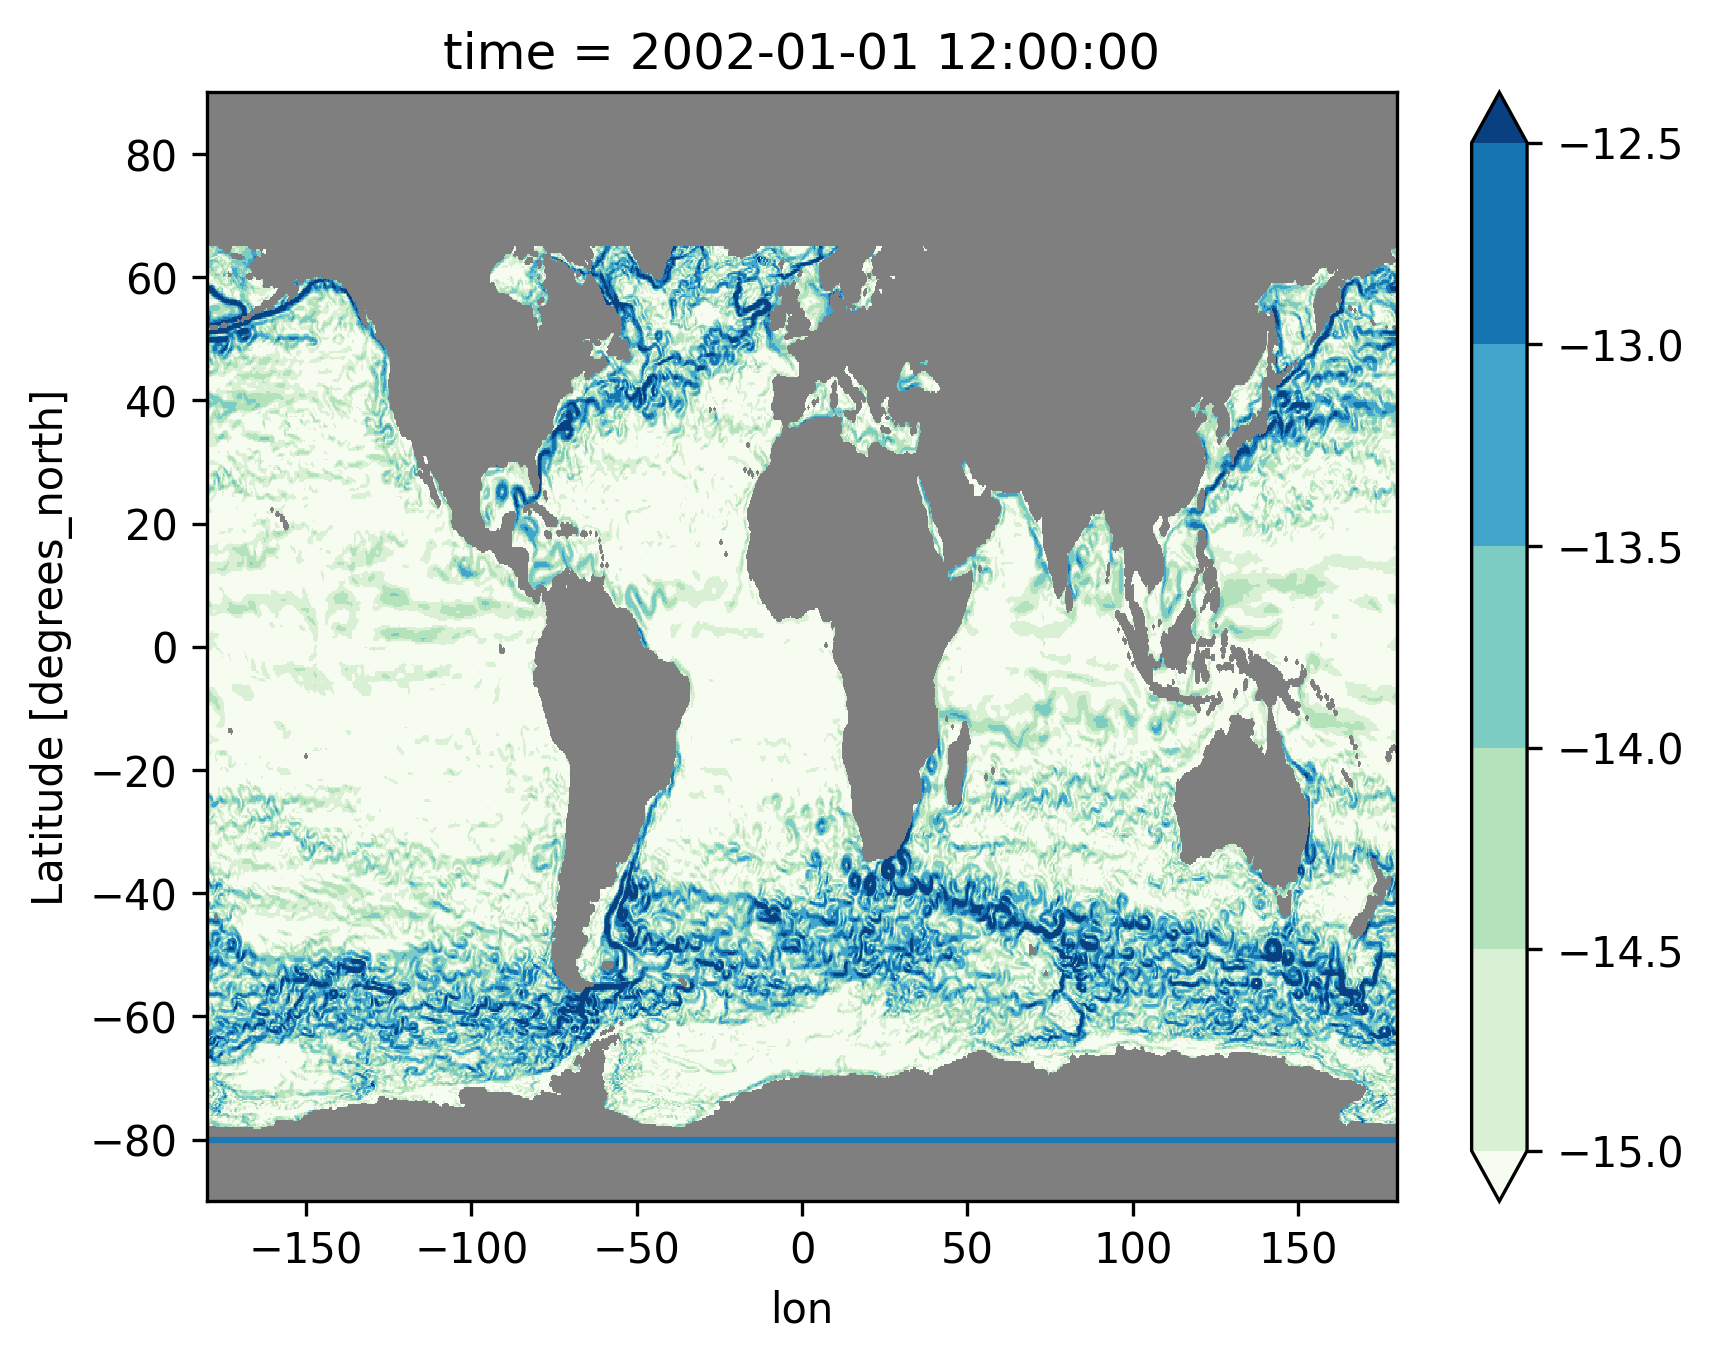

In [9]:
import matplotlib.colors as mcolors
cmap = plt.cm.GnBu
levels = [-15,-14.5, -14, -13.5, -13, -12.5]
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, extend='both')

plt.figure(dpi=300)
np.log(abs_grad(control_regrid)[0]).plot(cmap=cmap,norm=norm)
plt.axhline(y=-80)
plt.gca().set_facecolor('tab:gray')

In [19]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    obs_snapshots = np.log(abs_grad(obs)).compute()
    ann_snapshots = np.log(abs_grad(ann_regrid)).compute()
    control_snapshots = np.log(abs_grad(control_regrid)).compute()

[########################################] | 100% Completed | 24.53 s
[########################################] | 100% Completed | 19.31 s
[########################################] | 100% Completed | 20.91 s


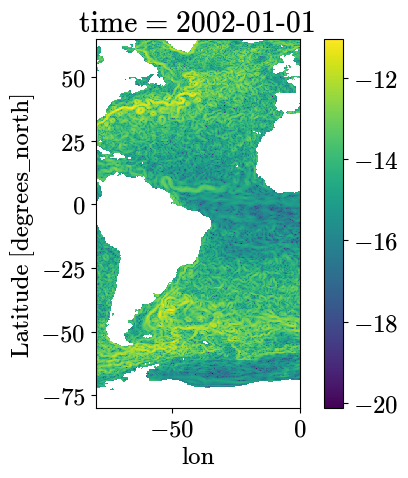

In [32]:
obs_snapshots[0].sel(lon=slice(-80,0), lat=slice(-80,65)).plot()
plt.gca().set_aspect('equal')

In [20]:
import cartopy.crs as ccrs
default_rcParams({'font.size':18, 'figure.subplot.hspace':0.0, 'figure.subplot.wspace':0.0})
def plot(idx=0):
    fig, axes = plt.subplots(
    nrows=2, ncols=2,
    figsize=(16, 8),
    subplot_kw={'projection':ccrs.Robinson()},
    dpi=300
    )
    axes=axes.flatten()
    obs_snapshots[idx].plot(ax=axes[2], cmap=cmap,norm=norm,transform=ccrs.PlateCarree(), rasterized=True, add_colorbar=False)
    #axes[0].set_extent([-180, 180, -80, 65], crs=ccrs.PlateCarree())
    axes[2].set_facecolor('tab:gray')
    axes[2].set_title('Observations')
    ann_snapshots[idx].plot(ax=axes[1], cmap=cmap,norm=norm,transform=ccrs.PlateCarree(), rasterized=True, add_colorbar=False)
    #axes[1].set_extent([-180, 180, -80, 65], crs=ccrs.PlateCarree())
    axes[1].set_facecolor('tab:gray')
    axes[1].set_title('ANN($1/4^\circ$)')
    im = control_snapshots[idx].plot(ax=axes[0], cmap=cmap,norm=norm,transform=ccrs.PlateCarree(), rasterized=True, add_colorbar=False)
    #axes[2].set_extent([-180, 180, -80, 65], crs=ccrs.PlateCarree())
    axes[0].set_facecolor('tab:gray')
    axes[0].set_title('Control($1/4^\circ$)')

    fig.delaxes(axes[3])

    cbar = plt.colorbar(im, ax=axes[0:3], shrink=0.85, pad=0.01)
    cbar.set_label('log|grad SSH|', fontsize=30)

    plt.suptitle(control_snapshots.time[idx].data, y=0.93)

In [126]:
import cartopy.crs as ccrs
default_rcParams({'font.size':18, 'figure.subplot.hspace':0.0, 'figure.subplot.wspace':0.0})
def plot2(idx=0):
    fig, axes = plt.subplots(
    nrows=1, ncols=2,
    figsize=(16, 4),
    subplot_kw={'projection':ccrs.Robinson()},
    dpi=300
    )
    ann_snapshots[idx].plot(ax=axes[1], cmap=cmap,norm=norm,transform=ccrs.PlateCarree(), rasterized=True, add_colorbar=False)
    axes[1].set_facecolor('tab:gray')
    axes[1].set_title('ANN($1/4^\circ$)')
    im = control_snapshots[idx].plot(ax=axes[0], cmap=cmap,norm=norm,transform=ccrs.PlateCarree(), rasterized=True, add_colorbar=False)
    axes[0].set_facecolor('tab:gray')
    axes[0].set_title('Control($1/4^\circ$)')

    cbar = plt.colorbar(im, ax=axes[0:2], shrink=0.85, pad=0.01)
    cbar.set_label('log|grad SSH|', fontsize=20)

    plt.suptitle(control_snapshots.time[idx].data, y=0.97)

CPU times: user 1.12 s, sys: 5.96 ms, total: 1.13 s
Wall time: 1.13 s


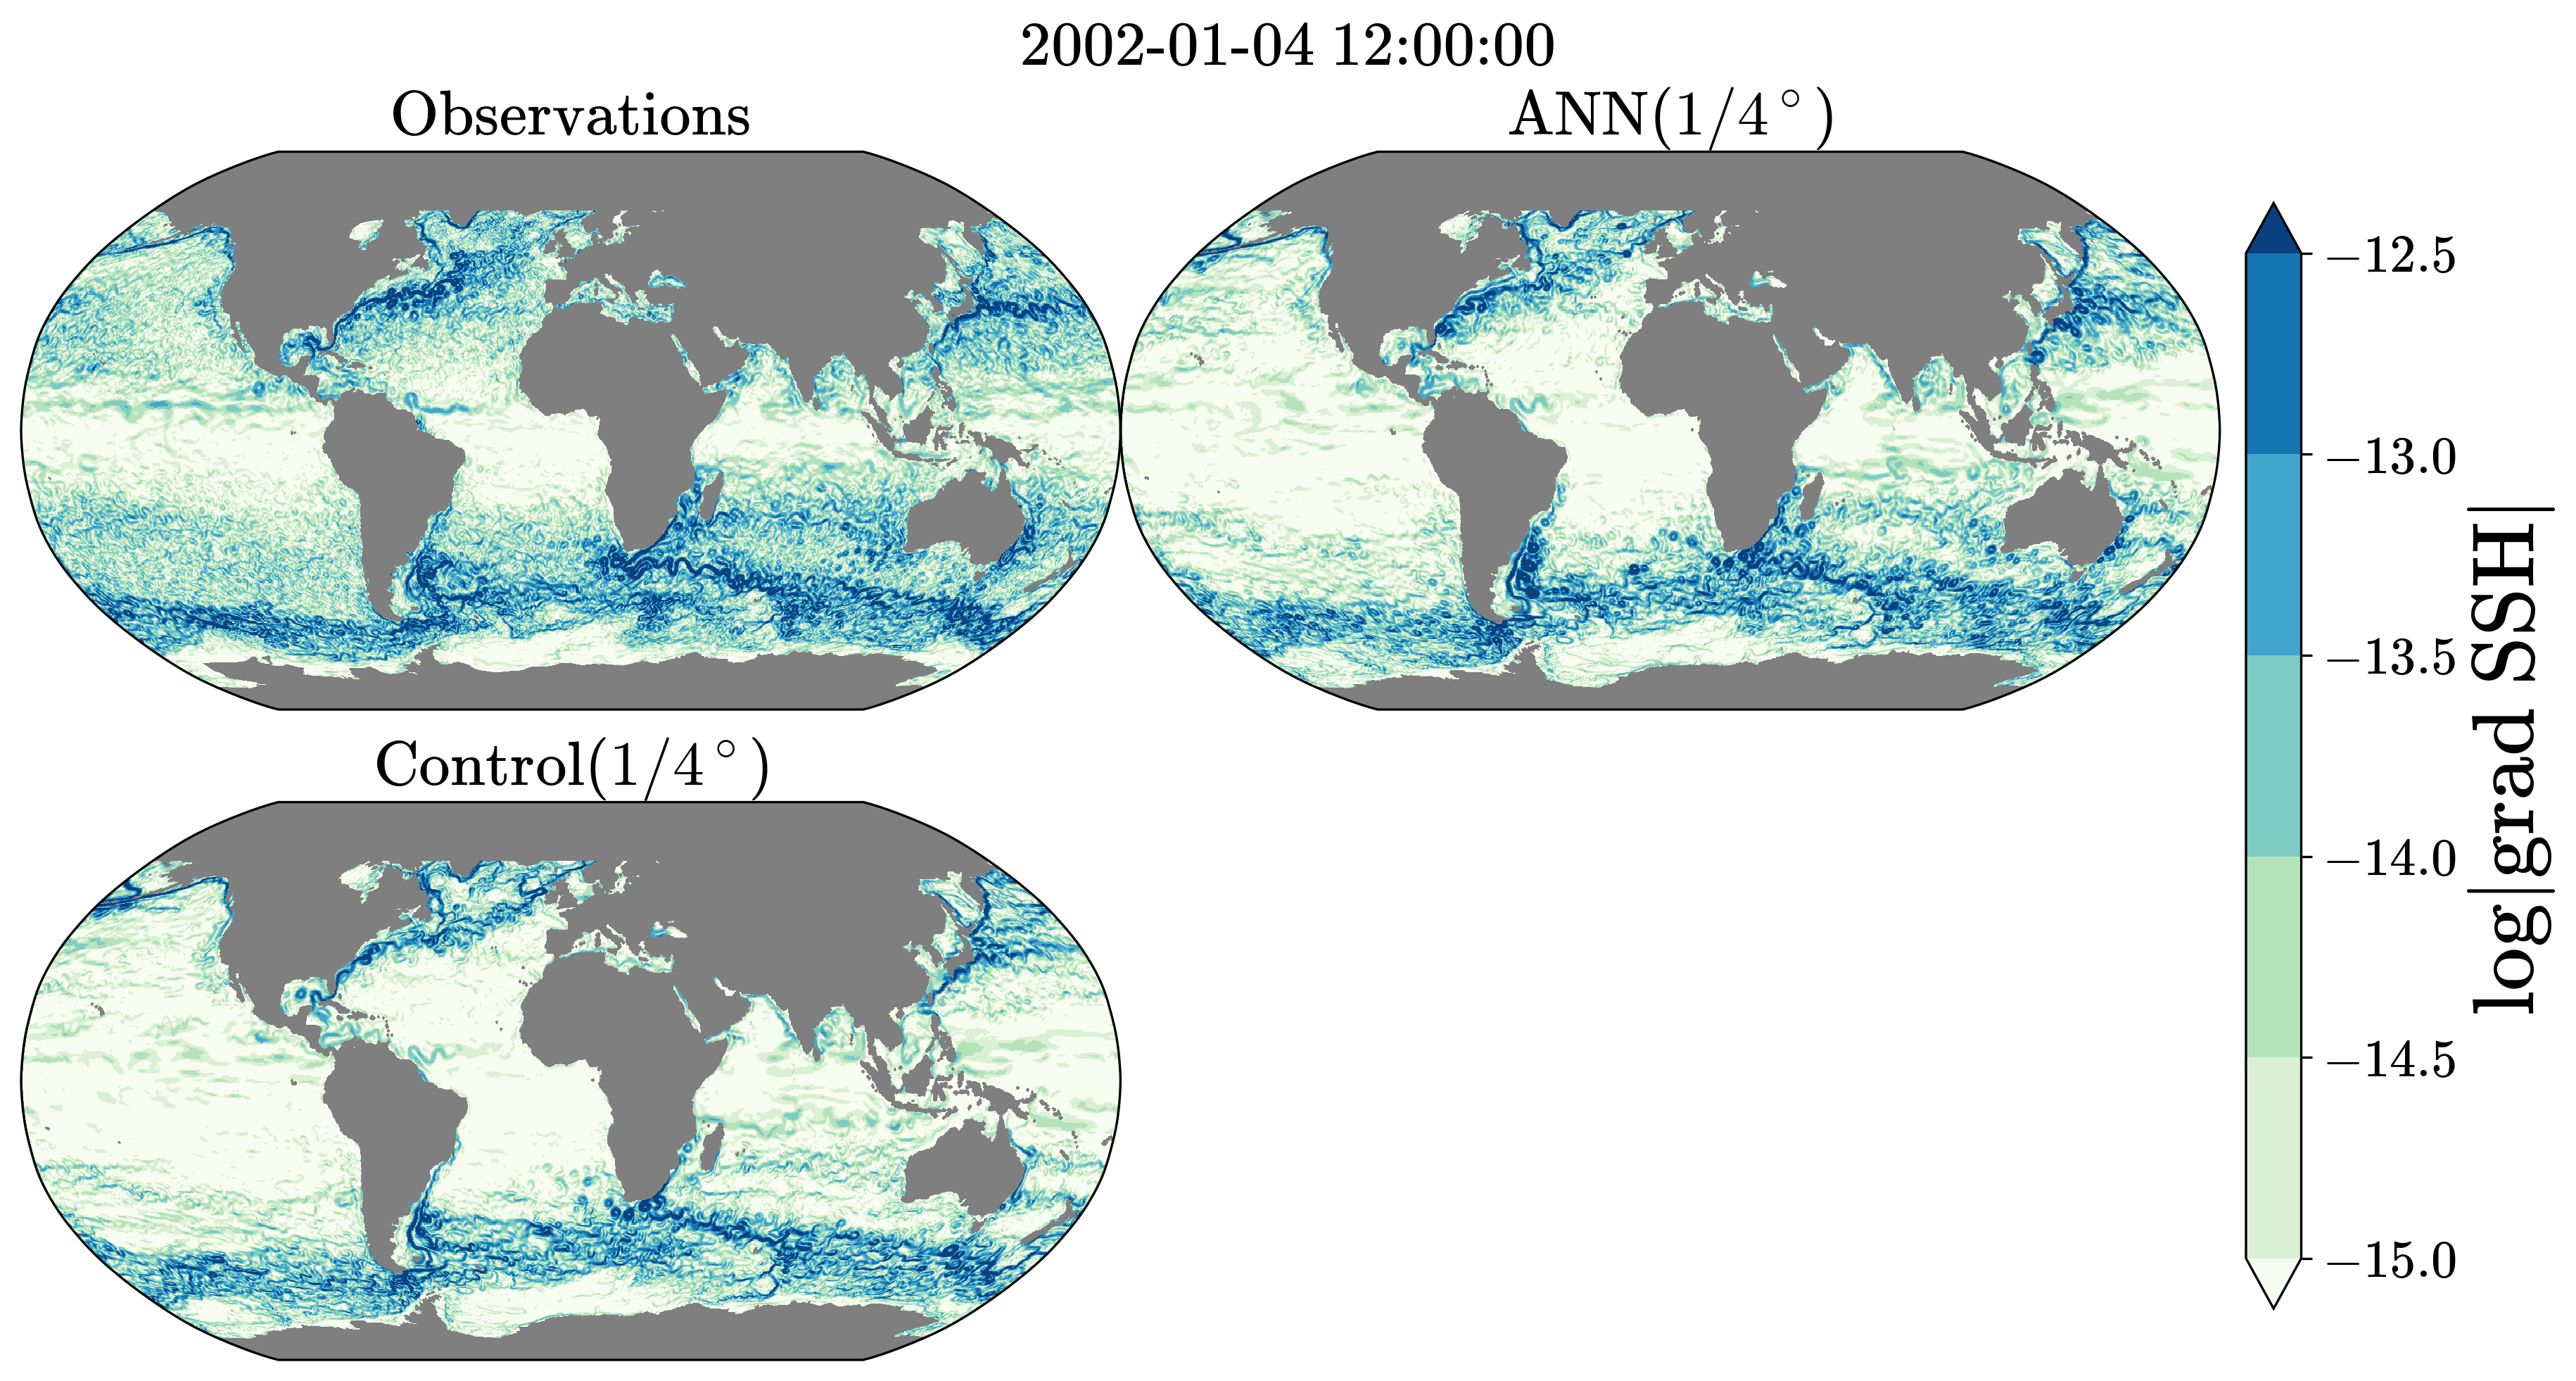

In [105]:
%time plot(1)

CPU times: user 747 ms, sys: 12 ms, total: 759 ms
Wall time: 761 ms


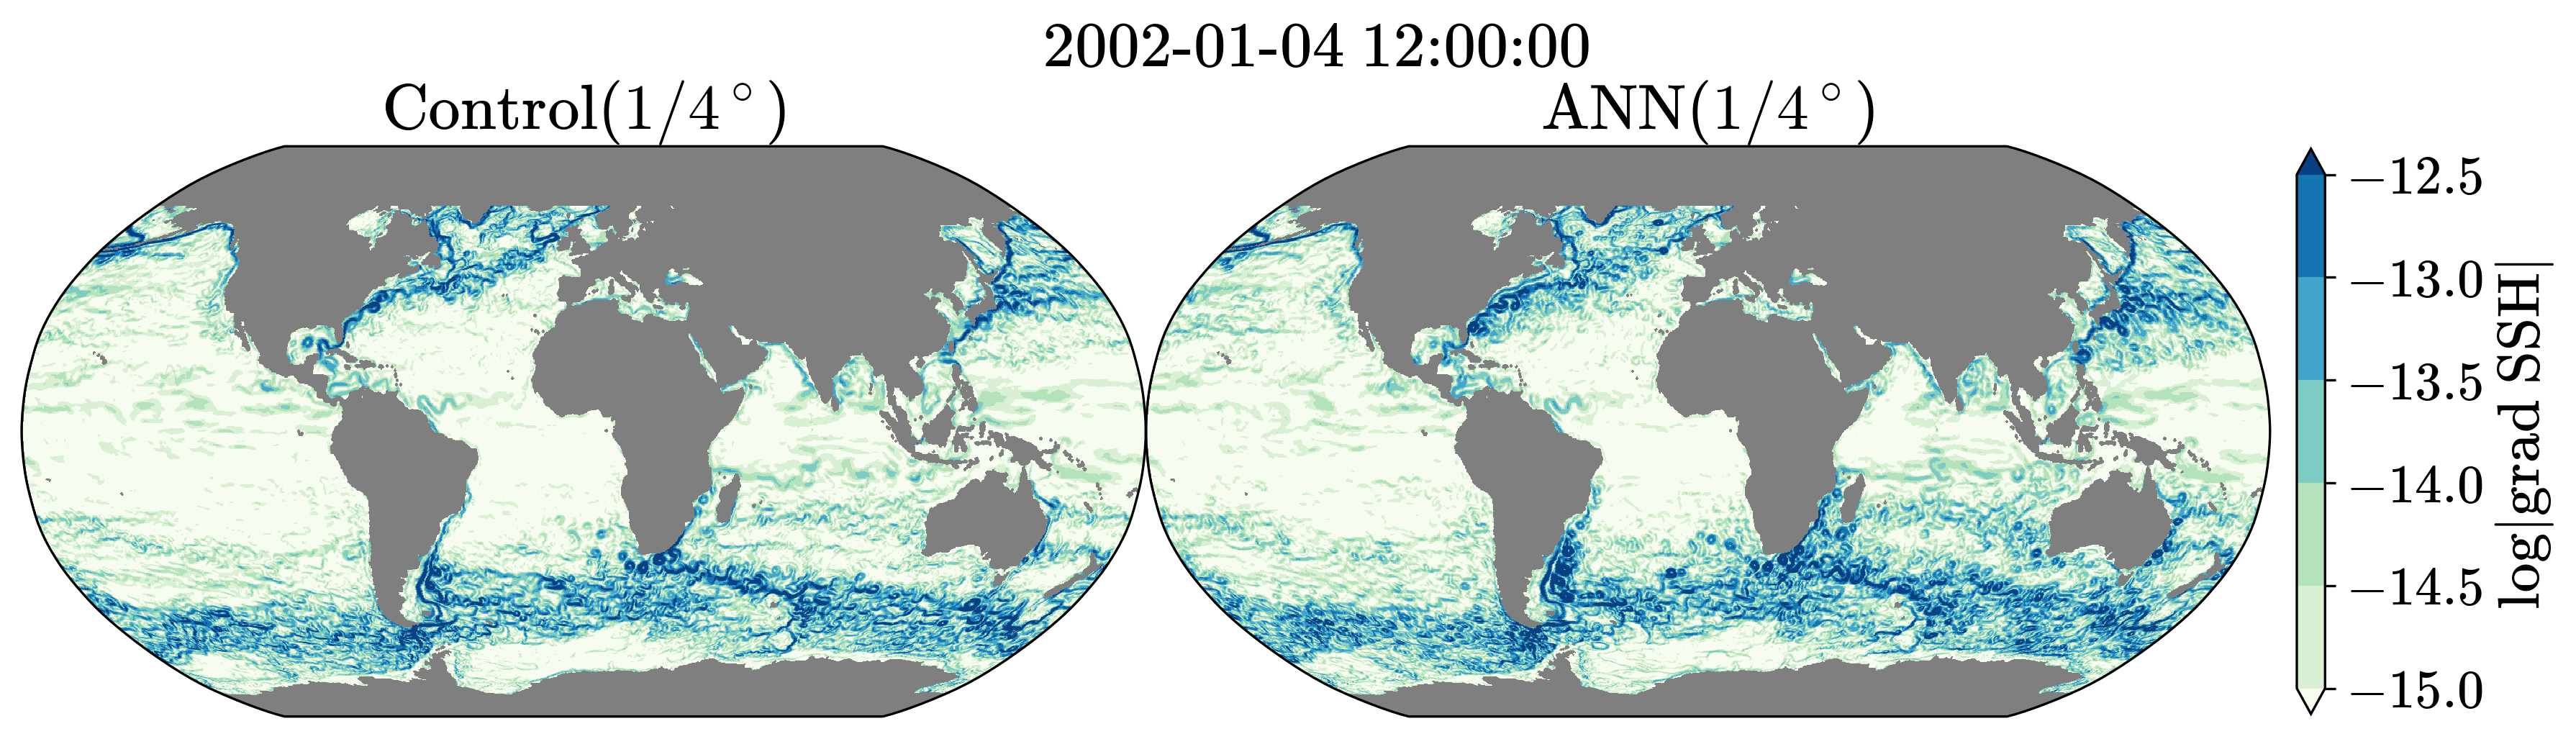

In [127]:
%time plot2(1)

In [96]:
import cartopy.crs as ccrs
default_rcParams({'figure.subplot.wspace': 0.1, 'figure.subplot.hspace': 0.3, 'font.size': 10})
def plot_Atlantic(idx=0):
    fig, axes = plt.subplots(
    nrows=1, ncols=3,
    figsize=(10, 8),
    dpi=300
    )

    lons = [-70,-50,-30,-10]
    control_snapshots[idx].sel(lon=slice(-82,0), lat=slice(-80,65)).plot(ax=axes[0], cmap=cmap,norm=norm,rasterized=True, add_colorbar=False)
    axes[0].set_facecolor('tab:gray')
    axes[0].set_aspect('equal')
    axes[0].set_title('Control($1/4^\circ$)',fontsize=14)
    axes[0].set_xticks(lons, [f'${-lon}^'+'{\circ}$W' for lon in lons])
    axes[0].set_ylabel('')
    axes[0].set_xlabel('')
    lats = [-80,-60, -40, -20, 0, 20, 40, 60]
    lat_ticks = [f'${-lat}^'+'{\circ}$S' if lat<0 else f'${lat}^'+'{\circ}$N' for lat in lats]
    axes[0].set_yticks(lats, lat_ticks)

    ann_snapshots[idx].sel(lon=slice(-82,0), lat=slice(-80,65)).plot(ax=axes[1], cmap=cmap,norm=norm,rasterized=True, add_colorbar=False)
    axes[1].set_facecolor('tab:gray')
    axes[1].set_aspect('equal')
    axes[1].set_title('ANN($1/4^\circ$)',fontsize=14)
    axes[1].set_yticks([])
    axes[1].set_xticks(lons, [f'${-lon}^'+'{\circ}$W' for lon in lons])
    axes[1].set_ylabel('')
    axes[1].set_xlabel('')

    im = obs_snapshots[idx].sel(lon=slice(-82,0), lat=slice(-80,65)).plot(ax=axes[2], cmap=cmap,norm=norm, rasterized=True, add_colorbar=False)
    axes[2].set_facecolor('tab:gray')
    axes[2].set_aspect('equal')
    axes[2].set_title('Observations',fontsize=14)
    axes[2].set_yticks([])
    axes[2].set_xticks(lons, [f'${-lon}^'+'{\circ}$W' for lon in lons])
    axes[2].set_ylabel('')
    axes[2].set_xlabel('')

    cbar = plt.colorbar(im, ax=axes[0:3], shrink=0.6, pad=0.01)
    cbar.set_label('log|grad SSH|', fontsize=14)

    plt.suptitle(control_snapshots.time[idx].data, y=0.78)

CPU times: user 99.3 ms, sys: 3.88 ms, total: 103 ms
Wall time: 103 ms


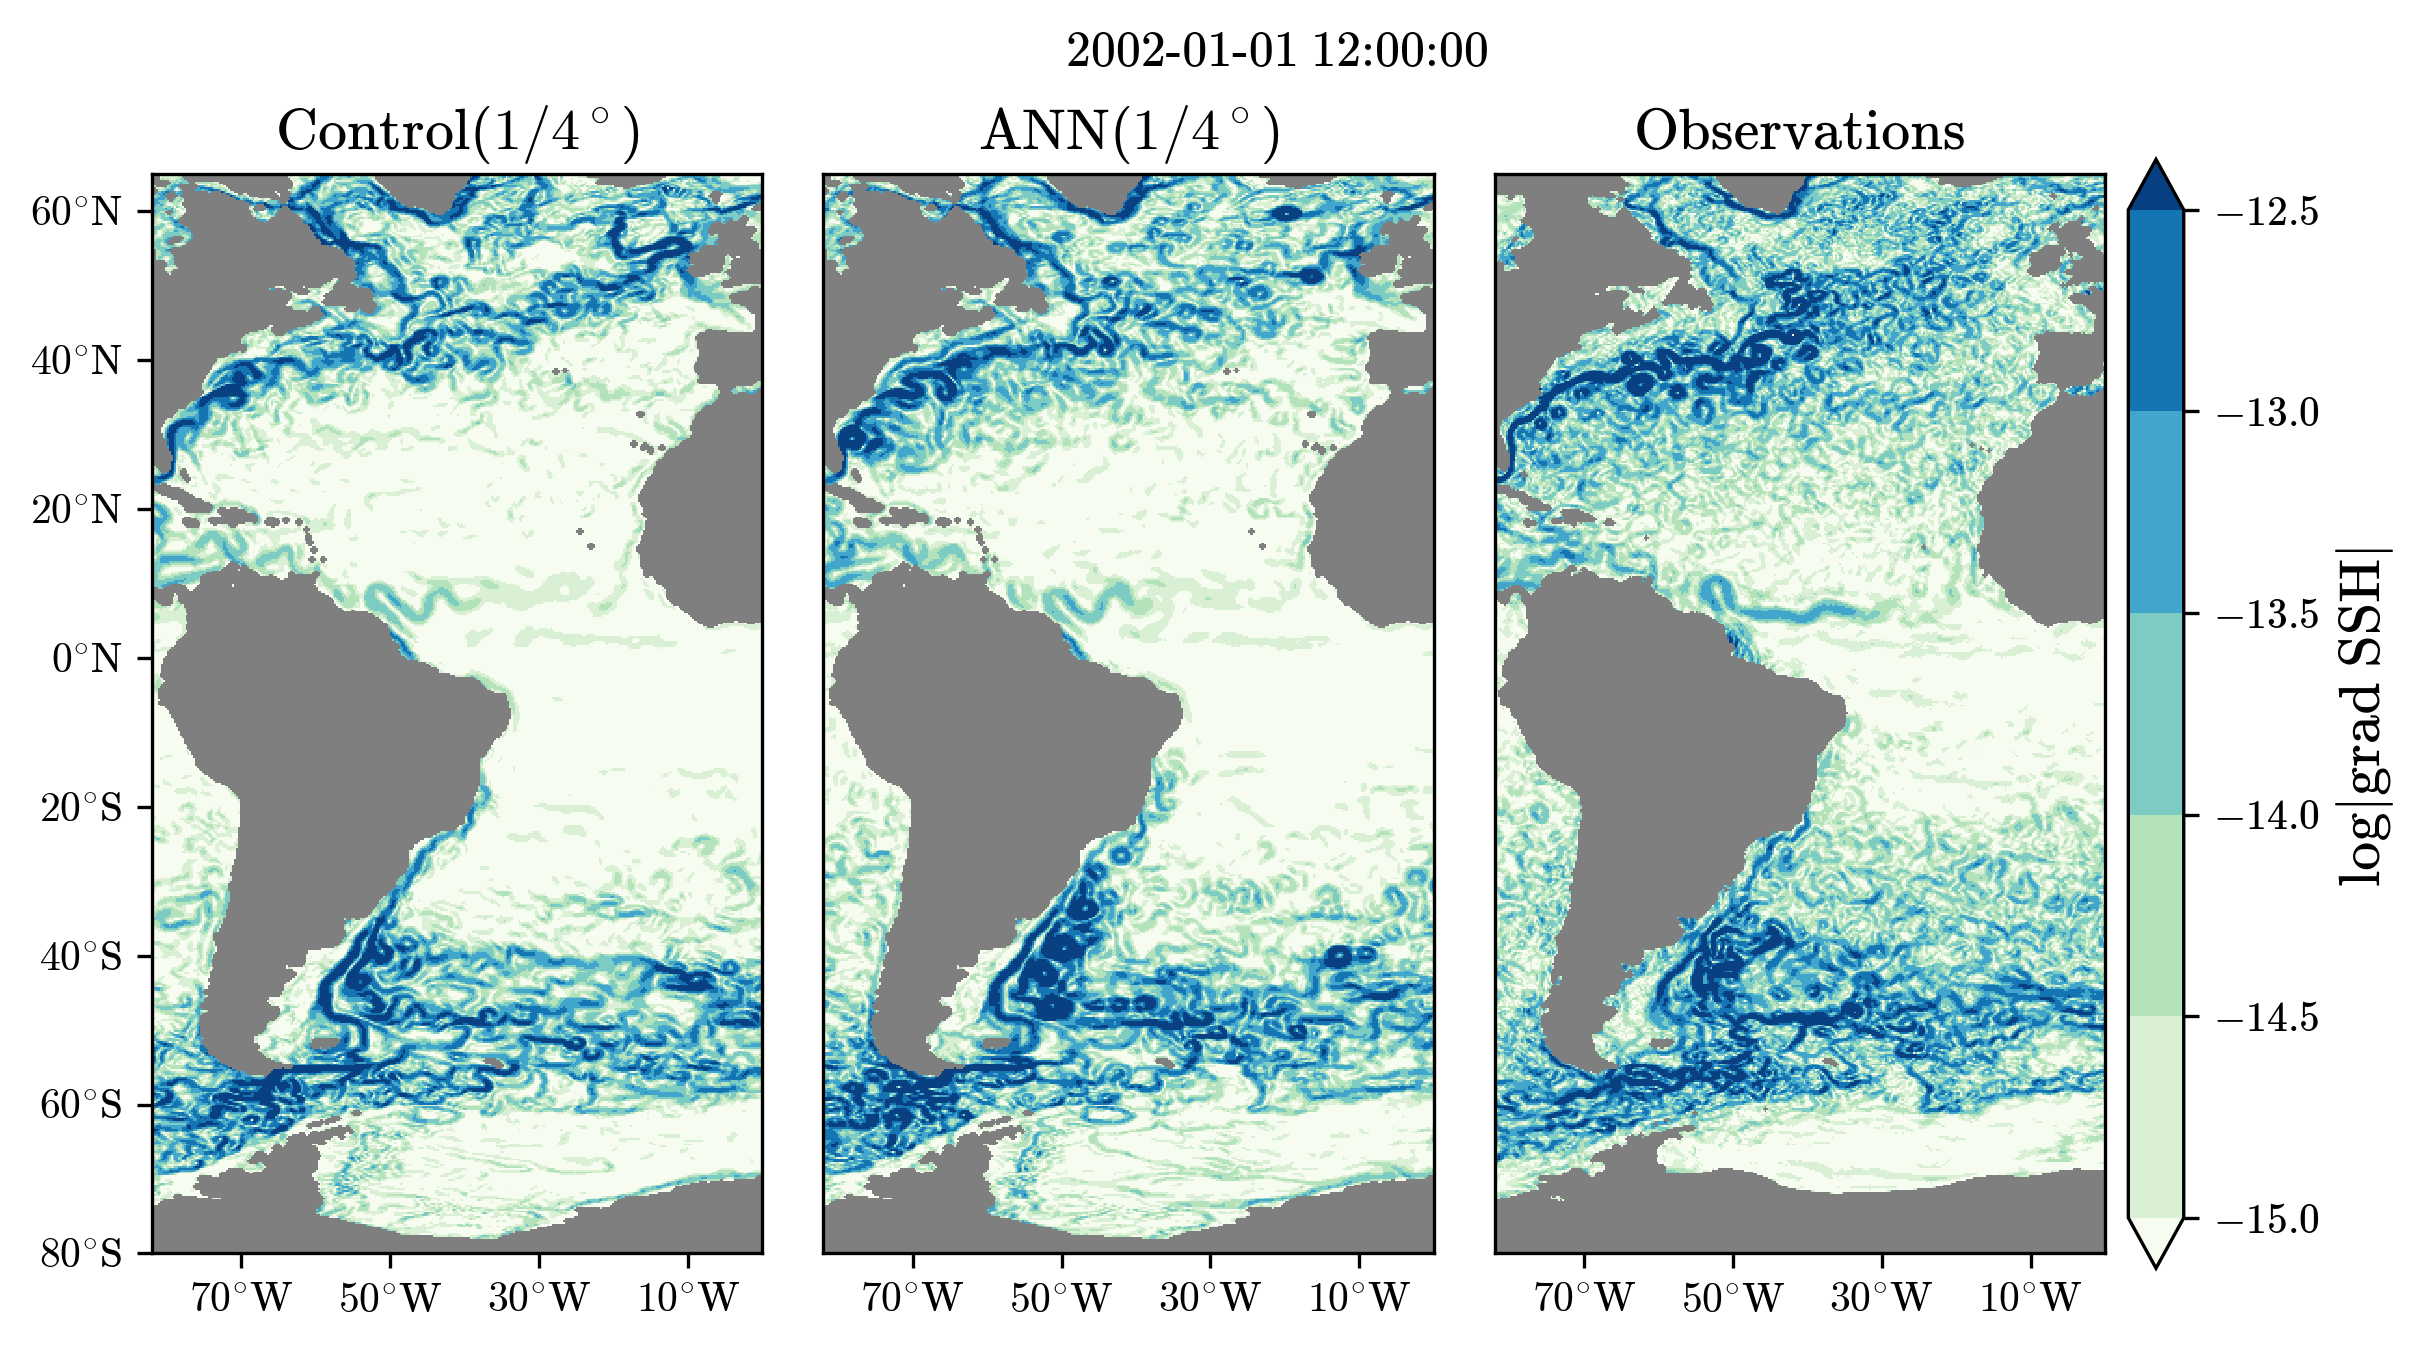

In [97]:
%time plot_Atlantic()

In [ ]:
from helpers.plot_helpers import create_animation_ffmpeg
%time create_animation_ffmpeg(plot2, range(0,244), FPS=20, filename='OM4-2.mp4', dpi=300)

In [ ]:
from helpers.plot_helpers import create_animation_ffmpeg
%time create_animation_ffmpeg(plot, range(0,244), FPS=20, filename='OM4-long.mp4', dpi=300)

In [108]:
from helpers.plot_helpers import create_animation_ffmpeg
%time create_animation_ffmpeg(plot_Atlantic, range(0,244), FPS=20, filename='OM4-Atlantic.mp4', resolution=[int(1256*10/7), 1000])

Frames already exists in folder .ffmpeg/OM4-Atlantic


Do you want to update snapshots?: [y/n] n


Frames are not updated

Resolution is set to 1794x1000

Animation OM4-Atlantic.mp4 at FPS=20 will last for 12.2 seconds. The frames are saved to 
.ffmpeg/OM4-Atlantic

Running the command:
cd /home/pp2681/ANN-momentum-mesoscale/assets; ffmpeg -y -framerate 20 -i .ffmpeg/OM4-Atlantic/frame-%d.png -s:v 1794x1000 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p OM4-Atlantic.mp4


sh: 1: module: not found
ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --en

CPU times: user 7.61 ms, sys: 2 ms, total: 9.6 ms
Wall time: 5.11 s


frame=  244 fps= 62 q=-1.0 Lsize=   21612kB time=00:00:12.05 bitrate=14692.7kbits/s speed=3.04x    
video:21609kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.017851%
[libx264 @ 0x556a6716e0c0] frame I:1     Avg QP:18.04  size:259176
[libx264 @ 0x556a6716e0c0] frame P:61    Avg QP:22.18  size:171587
[libx264 @ 0x556a6716e0c0] frame B:182   Avg QP:26.67  size: 62640
[libx264 @ 0x556a6716e0c0] consecutive B-frames:  0.4%  0.0%  1.2% 98.4%
[libx264 @ 0x556a6716e0c0] mb I  I16..4: 24.0% 35.8% 40.1%
[libx264 @ 0x556a6716e0c0] mb P  I16..4:  0.6%  4.5%  6.7%  P16..4:  9.3% 12.7% 12.9%  0.0%  0.0%    skip:53.2%
[libx264 @ 0x556a6716e0c0] mb B  I16..4:  0.1%  0.3%  0.5%  B16..8: 11.8%  8.2%  6.5%  direct:15.1%  skip:57.6%  L0:33.3% L1:32.3% BI:34.4%
[libx264 @ 0x556a6716e0c0] 8x8 transform intra:36.8% inter:27.6%
[libx264 @ 0x556a6716e0c0] coded y,uvDC,uvAC intra: 77.5% 83.0% 81.4% inter: 28.5% 19.5% 12.2%
[libx264 @ 0x556a6716e0c0] i16 v,h,dc,p: 57% 32% 11%  